In [7]:
import os, re, warnings
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, top_k_accuracy_score
)
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from flask import Flask, request, jsonify

warnings.filterwarnings("ignore")

In [8]:
# -----------------------------
# 1) CONFIG
# -----------------------------
MODEL_PATH = "models/assignee_model_v2.joblib"

PROJECTS = {
    "Aurora": {
        "issues":  r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for Aurora Project\\Aurora Issues 554.csv",
        "summary": r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for Aurora Project\\Aurora Issues summery 568.csv",
        "sprints": r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for Aurora Project\\Aurora Sprints 41.csv",
    },
    "Meso": {
        "issues":  r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for Meso Project\\Mesos Stories 176.csv",
        "summary": r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for Meso Project\\MESO Issue Summary 370.csv",
        "sprints": r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for Meso Project\\MESO Sprint 96.csv",
    },
    "SpringXD": {
        "issues":  r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for Spring XD Project by Randula\\Spring XD Issues 1992.csv",
        "summary": r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for Spring XD Project by Randula\\Spring XD Issues Summary 2861.csv",
        "sprints": r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for Spring XD Project by Randula\\Spring XD Sprints 67.csv",
    },
    "UserGrid": {
        "issues":  r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for UserGrid\\Usergrid Issues 824.csv",
        "summary": r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for UserGrid\\Usergrid Issues Summary 929.csv",
        "sprints": r"PM_Kaggle_dataset\\AgileScrumSprintVelocityDataSet\\Agile Scrum Dataset\\Finalized Datasets for UserGrid\\Usergrid Sprints 36.csv",
    },
}

In [9]:
# -----------------------------
# 2) HELPERS
# -----------------------------
def _lower_cols(df):
    df = df.copy()
    df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]
    return df

def safe_div(a,b,default=0.0):
    try:
        return float(a)/float(b) if b and not pd.isna(b) else default
    except: return default

def _parse_date(x):
    try: return pd.to_datetime(x, errors="coerce")
    except: return np.nan

def extract_label(summary, desc=""):
    """Simple keyword-based label extraction"""
    text = f"{summary} {desc}".lower()
    if any(k in text for k in ["ui", "react", "frontend", "css", "html", "layout", "component"]):
        return "frontend"
    if any(k in text for k in ["api", "backend", "server", "database", "controller", "prisma", "nest"]):
        return "backend"
    if any(k in text for k in ["deploy", "docker", "pipeline", "ci", "cd", "aws", "devops"]):
        return "devops"
    if any(k in text for k in ["test", "qa", "bug", "error", "issue"]):
        return "testing"
    return "general"

In [10]:
# -----------------------------
# 3) LOAD & MERGE ALL PROJECTS
# -----------------------------
combined = []
for pname, p in PROJECTS.items():
    try:
        iss = _lower_cols(pd.read_csv(p["issues"], on_bad_lines="skip", engine="python"))
        summ = _lower_cols(pd.read_csv(p["summary"], on_bad_lines="skip", engine="python"))
        spr  = _lower_cols(pd.read_csv(p["sprints"], on_bad_lines="skip", engine="python"))
    except Exception as e:
        print(f"⚠️ {pname}: error loading -> {e}")
        continue

    rename_map = {"priority": "priorityid", "priority_id": "priorityid", "storypoints": "storypoint"}
    iss.rename(columns={k:v for k,v in rename_map.items() if k in iss.columns}, inplace=True)

    # Sprint derived fields
    for c in ["sprintstartdate", "sprintenddate"]:
        if c in spr.columns:
            spr[c] = spr[c].apply(_parse_date)
    if "sprintlength" not in spr.columns:
        spr["sprintlength"] = (spr["sprintenddate"] - spr["sprintstartdate"]).dt.days.clip(lower=1)
    spr["velocity_sp_per_day"] = spr.apply(
        lambda r: safe_div(r.get("completedissuesestimatesum", 0), r.get("sprintlength", 0)), axis=1
    )

    # Merge
    join = summ.merge(spr, on="sprintid", how="left", suffixes=("","_spr"))
    if "issuekey" in join.columns and "key" in iss.columns:
        join = join.merge(
            iss[["key","storypoint","issuetype","status","assignee","priorityid","summary","description"]],
            left_on="issuekey", right_on="key", how="left"
        )

    # Extract label
    if "labels" not in join.columns:
        join["labels"] = join.apply(
            lambda r: extract_label(r.get("summary",""), r.get("description","")), axis=1
        )

    # Clean assignee
    if "assignee_x" in join.columns and "assignee_y" in join.columns:
        join["assignee"] = join["assignee_y"].fillna(join["assignee_x"])
    elif "assignee_x" in join.columns:
        join.rename(columns={"assignee_x": "assignee"}, inplace=True)
    elif "assignee_y" in join.columns:
        join.rename(columns={"assignee_y": "assignee"}, inplace=True)

    join["project"] = pname
    combined.append(join)

df = pd.concat(combined, ignore_index=True)
print("✅ Loaded combined shape:", df.shape)

✅ Loaded combined shape: (7054, 45)


In [11]:
# -----------------------------
# 4) FEATURES & TARGET
# -----------------------------
num_feats = ["storypoint","priorityid","velocity_sp_per_day","sprintlength","completedissuesestimatesum","noofdevelopers"]
cat_feats = ["issuetype","status","project","labels"]

for nf in num_feats:
    if nf not in df.columns: df[nf] = 0
for cf in cat_feats:
    if cf not in df.columns: df[cf] = "Unknown"

mask = df["assignee"].notna() & (df["assignee"] != "")
df = df[mask]

X = df[num_feats + cat_feats]
y = df["assignee"].astype(str)

print(f"Training samples: {len(X)} | Unique assignees: {y.nunique()}")

Training samples: 6533 | Unique assignees: 119


In [12]:
# -----------------------------
# 5) MODEL TRAINING (XGBoost)
# -----------------------------
pipe = Pipeline([
    ("prep", ColumnTransformer([
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler(with_mean=False))
        ]), num_feats),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_feats)
    ])),
    ("clf", XGBClassifier(
        n_estimators=400,
        learning_rate=0.1,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1
    ))
])

# Filter minimal samples per assignee
valid_assignees = y.value_counts()[y.value_counts() >= 2].index
mask = y.isin(valid_assignees)
X, y = X[mask], y[mask]

# --- Encode string labels (assignees) jadi angka ---
lbl = LabelEncoder()
y_encoded = lbl.fit_transform(y)

# Simpan encoder supaya nanti bisa dipakai lagi saat inferensi
joblib.dump(lbl, "models/assignee_label_encoder.joblib")

# --- Split dataset ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)

# decode kembali ke nama asli
y_pred_labels = lbl.inverse_transform(y_pred)
y_true_labels = lbl.inverse_transform(y_test)


Top-1 Accuracy: 0.458
Top-3 Accuracy: 0.707
Top-5 Accuracy: 0.808

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00        22
           2       1.00      0.75      0.86         4
           3       0.50      0.50      0.50         4
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       1.00      1.00      1.00         1
           7       0.33      0.50      0.40         2
           8       1.00      1.00      1.00        16
           9       0.60      0.78      0.68        32
          10       1.00      1.00      1.00         4
          11       0.88      0.64      0.74        11
          12       1.00      1.00      1.00         1
          13       0.68      0.63      0.65        83
          14       0.00      0.00      0.00         5
          15       0.30      0.33      0.31

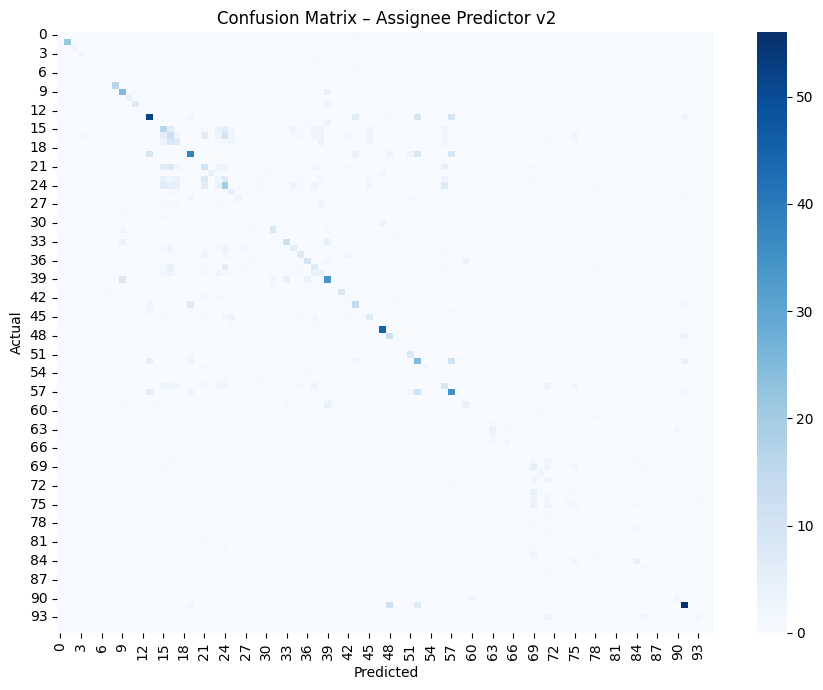

✅ Model saved to models/assignee_model_v2.joblib


In [13]:
# -----------------------------
# 6) EVALUATION
# -----------------------------
top1 = accuracy_score(y_test, y_pred)
top3 = top_k_accuracy_score(y_test, y_proba, k=3, labels=pipe.named_steps["clf"].classes_)
top5 = top_k_accuracy_score(y_test, y_proba, k=5, labels=pipe.named_steps["clf"].classes_)

print(f"\nTop-1 Accuracy: {top1:.3f}")
print(f"Top-3 Accuracy: {top3:.3f}")
print(f"Top-5 Accuracy: {top5:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix (optional)
plt.figure(figsize=(9,7))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap="Blues")
plt.title("Confusion Matrix – Assignee Predictor v2")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

joblib.dump(pipe, MODEL_PATH)
print(f"✅ Model saved to {MODEL_PATH}")

In [14]:
# -----------------------------
# 7) INFERENCE FUNCTION
# -----------------------------
lbl = joblib.load("models/assignee_label_encoder.joblib")

def predict_assignee(items, top_k=5):
    results = []
    for it in items:
        row = {**{k:0 for k in num_feats}, **{k:"Unknown" for k in cat_feats}}
        row.update(it)
        if "labels" not in row:
            row["labels"] = extract_label(row.get("summary",""), row.get("description",""))
        df_one = pd.DataFrame([row])

        proba = pipe.predict_proba(df_one[num_feats + cat_feats])[0]
        classes = lbl.inverse_transform(np.arange(len(proba)))

        top_idx = np.argsort(proba)[::-1][:top_k]
        top_preds = [
            {"assignee": classes[i], "probability": float(proba[i])}
            for i in top_idx
        ]
        results.append({"top_k_recommendations": top_preds})
    return results


In [15]:
# -----------------------------
# 8) LOCAL TEST
# -----------------------------
if __name__ == "__main__":
    dummy_items = [
        {"issuetype": "Story","status": "To Do","storypoint": 5,"priorityid": 3,"sprintlength": 14,
         "noofdevelopers": 6,"project": "Aurora","summary": "Create responsive UI for login","labels": "frontend"},
        {"issuetype": "Bug","status": "In Progress","storypoint": 2,"priorityid": 1,"sprintlength": 10,
         "noofdevelopers": 4,"project": "Meso","summary": "Fix backend API error","labels": "backend"},
    ]
    preds = predict_assignee(dummy_items)
    for i,res in enumerate(preds,1):
        print(f"\nTest #{i} → {dummy_items[i-1]['summary']}")
        for rank, rec in enumerate(res["top_k_recommendations"],1):
            print(f"  {rank}. {rec['assignee']} ({rec['probability']*100:.1f}%)")


Test #1 → Create responsive UI for login
  1. Kevin Sweeney (73.9%)
  2. Maxim Khutornenko (11.5%)
  3. Joe Smith (5.9%)
  4. Bill Farner (5.0%)
  5. Joshua Cohen (0.6%)

Test #2 → Fix backend API error
  1. Andrei Budnik (34.2%)
  2. Benjamin Bannier (28.1%)
  3. qianzhang (8.7%)
  4. Qian Zhang (8.0%)
  5. jamespeach (2.8%)
